# 2. Configuração do Ambiente

In [1]:
import os
import pathlib
import nrrd # pip install pynrrd
import matplotlib.pyplot as plt
import shutil 
import pandas as pd

# 3. Carregamento e Exploração dos Dados 

In [2]:
imgs_path = pathlib.Path('./images')

In [3]:
for file_name in os.listdir(imgs_path):
    print(file_name)

1-Original_Anon_Dicom
2-Rescaled_256_NRRD
3-Segmentation_NRRD
Patients.xlsx


In [4]:
seg_folder = '3-Segmentation_NRRD'
seg_path = imgs_path / seg_folder

rescaled_folder = '2-Rescaled_256_NRRD'
rescaled_imgs = imgs_path / rescaled_folder

print(seg_path)
print(rescaled_imgs)

images\3-Segmentation_NRRD
images\2-Rescaled_256_NRRD


In [5]:
masks = {}
masks_header = {}

# 3.2.1 Explorando arquivos .nrrd 

**Importando as mascaras do diretorio *3-Segmentation_NRRD* junto com suas informacoes (header)**

In [6]:
for file_name in os.listdir(seg_path):
    if(file_name.endswith('.nrrd')):
        file_path = str(seg_path / file_name)
        start = file_path.index(file_name)
        end = file_path.index('.seg.nrrd')
        mask_id = file_path[start:end]
        masks[mask_id], masks_header[mask_id] = nrrd.read(file_path)

**Testando se as imagens das mascaras foram importadas corretamente...**

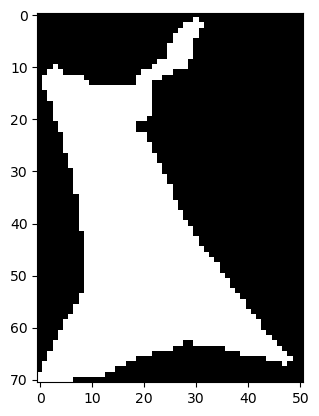

In [7]:
plt.imshow(masks['P2L1'][:,:,0], cmap='gray')

**Importando as imagens completas de ressonancia**

In [8]:
images = {}

In [9]:
for img_name in os.listdir(rescaled_imgs):
    if(img_name.endswith('.nrrd')):
        img_path = str(rescaled_imgs / img_name)
        start = img_path.index(img_name) 
        end = img_path.index('.nrrd')
        pacient_id = img_path[start:end]
        images[pacient_id] = nrrd.read(img_path)[0]

**Testando se as imagens completas de ressonancia foram importadas corretamente...**

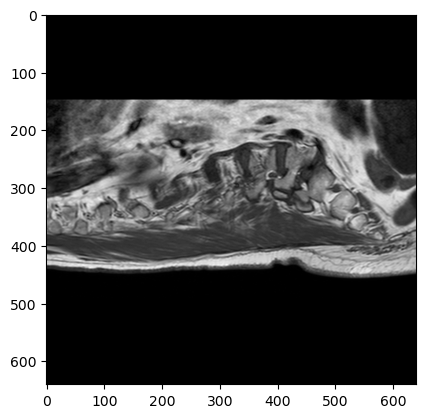

In [10]:
plt.imshow(images['P1'][:,:,1], cmap='gray')

# 3.2.3. Entendendo a Relação entre Máscaras e Imagens Originais

**Inspeciona a forma (dimensões) das imagens e máscaras**

In [11]:
print("Shape da máscara P1L1:", masks['P1L1'].shape)
print("Shape da imagem P1:", images['P1'].shape)

Shape da máscara P1L1: (70, 48, 5)
Shape da imagem P1: (640, 640, 14)


**Explora o cabeçalho da máscaras**

In [12]:
header_exemplo = masks_header['P1L1'] # ex paciente 1 vertebra l1

**Mostra todas as chaves disponíveis no cabeçalho**

In [13]:
print("\nChaves disponíveis no header da máscara P1L1:")
for k in header_exemplo.keys():
    print(" -", k)


Chaves disponíveis no header da máscara P1L1:
 - type
 - dimension
 - space
 - sizes
 - space directions
 - kinds
 - encoding
 - space origin
 - measurement frame
 - Segment0_Color
 - Segment0_ColorAutoGenerated
 - Segment0_Extent
 - Segment0_ID
 - Segment0_Name
 - Segment0_NameAutoGenerated
 - Segment0_Tags
 - Segmentation_ContainedRepresentationNames
 - Segmentation_ConversionParameters
 - Segmentation_MasterRepresentation
 - Segmentation_ReferenceImageExtentOffset


**Pega a posição de referência (coordenada da mascara/pedaço em relacao a img original)**


In [14]:
offset = header_exemplo.get('Segmentation_ReferenceImageExtentOffset', 'N/A')
print("\nOffset de referência da máscara dentro da imagem original:", offset)


Offset de referência da máscara dentro da imagem original: 267 182 5


# 4. Organizando os Arquivos por Classe


**Cria a coluna *"ClassNorm"* coloca dataframe com dados do xlsx dos Pacientes**

In [15]:
patient_info   = imgs_path / 'Patients.xlsx'
df = pd.read_excel(patient_info)
CLASS_MAP = {'benign':'BENIGN', 'malignant':'MALIGNANT',
             'BENIGN':'BENIGN', 'MALIGNANT':'MALIGNANT'}
df['ClassNorm'] = df['Class'].map(CLASS_MAP)
df

,Id,Age at the exam,Gender,Class,Segmented Vertebra,ClassNorm
0,P1,67,F,benign,L1,BENIGN
1,P2,61,F,benign,L1/L3/L5,BENIGN
2,P3,65,M,benign,L1,BENIGN
3,P4,84,M,benign,L3,BENIGN
4,P5,78,F,benign,L1/L4,BENIGN
...,...,...,...,...,...,...
86,P87,72,F,malignant,L5,MALIGNANT
87,P88,68,M,malignant,L4,MALIGNANT
88,P89,77,M,malignant,L5,MALIGNANT
89,P90,55,M,malignant,L4,MALIGNANT


**Cria subpastas de saída (BENIGN, MALIGNANT)**


In [16]:
for cls in ['BENIGN', 'MALIGNANT']:
    (imgs_path/rescaled_folder/cls).mkdir(exist_ok=True, parents=True)
    (imgs_path/seg_folder/cls).mkdir(exist_ok=True, parents=True)

**Lê linha a linha do xlxs de Pacientes e move as benignas e malignas dos pacientes para sua pasta correspondente**

In [17]:
# Função auxiliar para copiar arquivos com segurança
def copy_if_exists(src_path: pathlib.Path, dst_dir: pathlib.Path):
    if src_path.exists():
        dst = dst_dir / src_path.name
        if not dst.exists():
            shutil.copy2(src_path, dst)
        return True
    return False

moved_images = moved_masks = 0

for _, row in df.iterrows():
    pid = str(row['Id']).strip()    # esperado 'P1', 'P2', ...
    cls = row['ClassNorm']
    if cls not in ('BENIGN','MALIGNANT'):
        print(f"[AVISO] Classe inválida para {pid}: {row['Class']}")
        continue

    cand_img = imgs_path / rescaled_folder / f"{pid}.nrrd"
    ok_img = copy_if_exists(cand_img, imgs_path/rescaled_folder/cls)
    moved_images += int(ok_img)

    # máscaras do paciente (em 3-Segmentation_NRRD): P{n}L{*}.seg.nrrd (ou .nrrd)
    for fn in os.listdir(imgs_path/seg_folder):
        if fn.lower().endswith('.nrrd') and fn.startswith(pid):
            ok_m = copy_if_exists((imgs_path/seg_folder/fn), (imgs_path/seg_folder/cls))
            moved_masks += int(ok_m)

print(f"Imagens copiadas: {moved_images}")
print(f"Máscaras copiadas: {moved_masks}")

Imagens copiadas: 91
Máscaras copiadas: 244


# 5. Processamento das Imagens e Extração de Patches 

In [18]:
# continua ...